# Sistema de Recomendación de Cultivos
## Parte 2: Modelado y Evaluación (Fases 3-6 CRISP-DM)

**Machine Learning**

**Profesor:** Marco Terán  
**Fecha:** 2025/10/22

**Integrantes**

- Daniel Alejandro Garcia Zuluaica
- Edward Alejandro Rayo Cortés
- Elizabeth Toro Chalarca

___

## 📋 Tabla de Contenidos

1. **Resumen del EDA** (Referencia del Notebook 1)
2. **Fase 3: Preparación de Datos**
3. **Fase 4: Modelado**
4. **Fase 5: Evaluación**
5. **Fase 6: Despliegue**
6. **Conclusiones y Próximos Pasos**

---

## 📚 Resumen del EDA (Notebook 1)

Este notebook continúa el trabajo realizado en [1_crops_eda.ipynb](1_crops_eda.ipynb). A continuación, un resumen ejecutivo de los hallazgos clave:

### Calidad de Datos: ⭐⭐⭐⭐⭐ EXCELENTE

- **Completitud**: 100% (sin valores faltantes)
- **Balance**: Perfecto (100 muestras × 22 cultivos = 2,200 muestras)
- **Variables**: 7 numéricas (N, P, K, temperature, humidity, ph, rainfall)
- **Target**: 22 clases de cultivos

### Hallazgos Clave del EDA:

1. ✅ **Outliers válidos**: Representan requerimientos agronómicos específicos (conservar)
2. ✅ **Variables significativas**: Todas con F-statistic alto (p < 0.05)
3. ✅ **Separabilidad confirmada**: Silhouette Score t-SNE = 0.528 (buena separación)
4. ⚠️ **Distribuciones no normales**: Requiere transformación para modelos paramétricos
5. ⚠️ **Multicolinealidad P-K**: Correlación 0.736 (manejable con regularización)

### Decisiones para Modelado:

| Decisión | Justificación |
|----------|---------------|
| **Conservar outliers** | Agronómicamente válidos |
| **Usar 7 variables** | Todas discriminan significativamente |
| **RobustScaler** | Resistente a outliers |
| **PowerTransformer** | Para modelos paramétricos |
| **Modelos no-lineales** | PCA mostró que no hay separación lineal |

### Expectativas de Performance:

- **Objetivo mínimo**: 85% accuracy
- **Objetivo realista**: 90-93% accuracy
- **Objetivo óptimo**: ≥95% accuracy

### Modelos Prioritarios:

1. 🥇 **Random Forest**: Robusto, maneja outliers, captura interacciones
2. 🥇 **XGBoost**: State-of-art para multiclase
3. 🥈 **Logistic Regression**: Baseline interpretable
4. 🥈 **Decision Tree**: Simple, interpretable, exploración inicial

---

## 1. Configuración del Entorno

In [35]:
pip install -r ../requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
# Configuración inicial
import sys
import warnings
warnings.filterwarnings('ignore')

# Verificar versión de Python
assert sys.version_info >= (3, 7), "Este notebook requiere Python 3.7 o superior"
print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor} instalado correctamente")

✅ Python 3.12 instalado correctamente


In [37]:
# Importar librerías para modelado
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn para modelado
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# XGBoost (si está instalado)
try:
    import xgboost as xgb
    print("✅ XGBoost disponible")
except ImportError:
    print("⚠️  XGBoost no instalado (opcional)")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Random state para reproducibilidad
RANDOM_STATE = 42

print("\n✅ Librerías importadas correctamente")

✅ XGBoost disponible

✅ Librerías importadas correctamente


In [38]:
#importar funciones utilitarias implementads en el directorio src
import sys
sys.path.append('../src')

In [39]:
import importlib
import data_split
importlib.reload(data_split)

from data_split import get_train_test_split


---

## 2. Carga de Datos

Cargamos el dataset limpio (ya validado en el EDA):

In [40]:
# Obtener split Train/Test (automáticamente usa el mismo split que los otros notebooks)
data = get_train_test_split()

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
label_encoder = data['label_encoder']

print(f"\n" + "="*80)
print("DATOS CARGADOS Y LISTOS PARA MODELADO".center(80))
print("="*80)
print(f"\n✅ Split cargado exitosamente")
print(f"   - Train: {len(X_train)} muestras × {X_train.shape[1]} features")
print(f"   - Test: {len(X_test)} muestras × {X_test.shape[1]} features")
print(f"   - Clases: {len(label_encoder.classes_)}")
print(f"\n📊 Features disponibles:")
print(f"   {data['feature_names']}")
print(f"\n🌾 Cultivos (primeras 10):")
print(f"   {data['class_names'][:10]}")
if len(data['class_names']) > 10:
    print(f"   ... y {len(data['class_names']) - 10} más")


                     CARGANDO SPLIT TRAIN/TEST DESDE CACHE                      

✅ Split cargado desde cache: train_test_split_cache.pkl

📊 Información del Split:
   - Train samples: 1760 (80.0%)
   - Test samples: 440 (20.0%)
   - Features: 7
   - Clases: 22
   - Random state: 42
   - Test size: 0.2

                     DATOS CARGADOS Y LISTOS PARA MODELADO                      

✅ Split cargado exitosamente
   - Train: 1760 muestras × 7 features
   - Test: 440 muestras × 7 features
   - Clases: 22

📊 Features disponibles:
   ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

🌾 Cultivos (primeras 10):
   ['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'kidneybeans']
   ... y 12 más


### 3.4. Pipelines de Preprocesamiento

Creamos diferentes pipelines de preprocesamiento según el tipo de modelo:

- **Modelos paramétricos** (Logistic Regression): **RobustScaler** (resistente a outliers según EDA)
- **Modelos basados en árboles** (Decision Tree, Random Forest, XGBoost): Sin normalización (datos raw)

In [41]:
# ============================================
# 3.4. Pipelines de Preprocesamiento
# ============================================

# Crear RobustScaler (decisión del EDA: resistente a outliers válidos)
robust_scaler = RobustScaler()

# Ajustar escalador solo con datos de entrenamiento (evitar data leakage)
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

print("="*80)
print("PIPELINES DE PREPROCESAMIENTO".center(80))
print("="*80)

# Verificar transformación
print(f"\n✅ RobustScaler aplicado (según conclusiones del EDA):")
print(f"   - Mediana en train (debe ser ~0): {np.median(X_train_scaled, axis=0).round(10)[:3]}")
print(f"   - IQR en train: {(np.percentile(X_train_scaled, 75, axis=0) - np.percentile(X_train_scaled, 25, axis=0)).round(3)[:3]}")

print(f"\n✅ Datos sin escalar (para modelos basados en árboles):")
print(f"   - X_train (raw) - rango: [{X_train.min().min():.2f}, {X_train.max().max():.2f}]")

# Crear diccionario con los datos preparados
prepared_data = {
    'raw': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': None
    },
    'scaled': {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': robust_scaler
    }
}

print(f"\n✅ Datos preparados listos para modelado:")
print(f"   - 'raw': Sin normalización (Decision Tree, Random Forest, XGBoost)")
print(f"   - 'scaled': RobustScaler (Logistic Regression)")
print(f"\n📦 Diccionario 'prepared_data' creado con ambas variantes")

                         PIPELINES DE PREPROCESAMIENTO                          

✅ RobustScaler aplicado (según conclusiones del EDA):
   - Mediana en train (debe ser ~0): [0. 0. 0.]
   - IQR en train: [1. 1. 1.]

✅ Datos sin escalar (para modelos basados en árboles):
   - X_train (raw) - rango: [0.00, 298.56]

✅ Datos preparados listos para modelado:
   - 'raw': Sin normalización (Decision Tree, Random Forest, XGBoost)
   - 'scaled': RobustScaler (Logistic Regression)

📦 Diccionario 'prepared_data' creado con ambas variantes


### 3.5. Validación de la Preparación

Verificamos que todo esté correcto antes de proceder al modelado:

In [42]:
# ============================================
# 3.5. Validación de la Preparación
# ============================================

print("="*80)
print("VALIDACIÓN FINAL DE PREPARACIÓN DE DATOS".center(80))
print("="*80)

# 1. Verificar dimensiones
print(f"\n1️⃣ VERIFICACIÓN DE DIMENSIONES:")
print(f"   ✅ X_train: {X_train.shape}")
print(f"   ✅ X_test: {X_test.shape}")
print(f"   ✅ y_train: {y_train.shape}")
print(f"   ✅ y_test: {y_test.shape}")
assert X_train.shape[1] == X_test.shape[1] == 7, "❌ Error: Número de features inconsistente"
assert len(y_train) == X_train.shape[0], "❌ Error: Dimensiones train inconsistentes"
assert len(y_test) == X_test.shape[0], "❌ Error: Dimensiones test inconsistentes"

# 2. Verificar ausencia de valores faltantes
print(f"\n2️⃣ VERIFICACIÓN DE VALORES FALTANTES:")
x_train_nan = X_train.isna().sum().sum()
x_test_nan = X_test.isna().sum().sum()
y_train_nan = pd.isna(y_train).sum()
y_test_nan = pd.isna(y_test).sum()
print(f"   {'✅' if x_train_nan == 0 else '❌'} X_train: {x_train_nan} valores faltantes")
print(f"   {'✅' if x_test_nan == 0 else '❌'} X_test: {x_test_nan} valores faltantes")
print(f"   {'✅' if y_train_nan == 0 else '❌'} y_train: {y_train_nan} valores faltantes")
print(f"   {'✅' if y_test_nan == 0 else '❌'} y_test: {y_test_nan} valores faltantes")
assert not X_train.isna().any().any(), "❌ Error: NaN en X_train"
assert not X_test.isna().any().any(), "❌ Error: NaN en X_test"

# 3. Verificar balance de clases
print(f"\n3️⃣ VERIFICACIÓN DE BALANCE DE CLASES:")
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()
print(f"   ✅ Clases en train: {len(train_counts)} clases")
print(f"   ✅ Clases en test: {len(test_counts)} clases")
print(f"   ✅ Muestras por clase (train): min={train_counts.min()}, max={train_counts.max()}")
print(f"   ✅ Muestras por clase (test): min={test_counts.min()}, max={test_counts.max()}")
assert len(train_counts) == len(test_counts) == 22, "❌ Error: Número de clases inconsistente"

# 4. Verificar rangos de datos (sin escalar aún)
print(f"\n4️⃣ VERIFICACIÓN DE RANGOS:")
print(f"   ✅ X_train - rango: [{X_train.min().min():.2f}, {X_train.max().max():.2f}]")
print(f"   ✅ X_test - rango: [{X_test.min().min():.2f}, {X_test.max().max():.2f}]")

# 5. Resumen final
print(f"\n" + "="*80)
print("✅ PREPARACIÓN DE DATOS COMPLETADA EXITOSAMENTE".center(80))
print("="*80)
print(f"\n📊 Resumen:")
print(f"   - Total de muestras: {len(X_train) + len(X_test)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"   - Características: {X_train.shape[1]} variables numéricas")
print(f"   - Clases: {len(label_encoder.classes_)} cultivos diferentes")
print(f"   - Split: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% / {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"   - Estratificado: Sí (mantiene proporción de clases)")
print(f"\n🚀 Listo para la Fase 4: Modelado")


                    VALIDACIÓN FINAL DE PREPARACIÓN DE DATOS                    

1️⃣ VERIFICACIÓN DE DIMENSIONES:
   ✅ X_train: (1760, 7)
   ✅ X_test: (440, 7)
   ✅ y_train: (1760,)
   ✅ y_test: (440,)

2️⃣ VERIFICACIÓN DE VALORES FALTANTES:
   ✅ X_train: 0 valores faltantes
   ✅ X_test: 0 valores faltantes
   ✅ y_train: 0 valores faltantes
   ✅ y_test: 0 valores faltantes

3️⃣ VERIFICACIÓN DE BALANCE DE CLASES:
   ✅ Clases en train: 22 clases
   ✅ Clases en test: 22 clases
   ✅ Muestras por clase (train): min=80, max=80
   ✅ Muestras por clase (test): min=20, max=20

4️⃣ VERIFICACIÓN DE RANGOS:
   ✅ X_train - rango: [0.00, 298.56]
   ✅ X_test - rango: [0.00, 286.51]

                 ✅ PREPARACIÓN DE DATOS COMPLETADA EXITOSAMENTE                 

📊 Resumen:
   - Total de muestras: 2200 (Train: 1760, Test: 440)
   - Características: 7 variables numéricas
   - Clases: 22 cultivos diferentes
   - Split: 80.0% / 20.0%
   - Estratificado: Sí (mantiene proporción de clases)

🚀 Listo para 

---

## 🤖 Fase 4: Modelado

En esta fase entrenaremos y compararemos 4 modelos de clasificación:

1. **Logistic Regression**: Modelo lineal baseline (con RobustScaler)
2. **Decision Tree**: Modelo no-lineal interpretable
3. **Random Forest**: Ensemble de árboles robusto
4. **XGBoost**: Modelo gradient boosting state-of-the-art

### Estrategia de Modelado:

- **Datos escalados** (RobustScaler): Para Logistic Regression
- **Datos sin escalar**: Para modelos basados en árboles (Decision Tree, Random Forest, XGBoost)
- **Random State = 42**: Para reproducibilidad
- **Evaluación**: Accuracy y F1-Score en train y test

### 4.1. Definición de Modelos

Configuramos los 4 modelos con sus hiperparámetros iniciales:

In [54]:
# ============================================
# 4.1. Definición de Modelos
# ============================================

# NOTA: Los hiperparámetros de XGBoost mostrados aquí son los valores OPTIMIZADOS
# obtenidos del notebook 2.5_hyperparameter_optimization.ipynb usando
# RandomizedSearchCV con 5-Fold Cross-Validation.
#
# 🏆 XGBoost fue el modelo GANADOR:
#    - CV Score: 99.60%
#    - Test Accuracy: 99.32%
#    - Test F1-Score: 99.33%

# Definir modelos con configuración inicial
models = {
    'Logistic_Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        multi_class='multinomial',
        max_iter=100,
        solver='saga',
        penalty='l2',
    ),
    'Decision_Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=25,
        min_samples_split=10,
        min_samples_leaf=1,
        criterion='gini',
    ),
    'Random_Forest': RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=2,
        max_features='sqrt',
        max_depth=20,
    ),
    'XGBoost': xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        objective='multi:softmax',
        num_class=22,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_jobs=-1,
        subsample=1.0,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        gamma=0.1,
        colsample_bytree=0.7,
    )
}

# Mapeo de modelos a sus datos correspondientes,
model_data_mapping = {
    'Logistic_Regression': 'scaled',  # Usa RobustScaler
    'Decision_Tree': 'raw',
    'Random_Forest': 'raw',
    'XGBoost': 'raw'
}

print("="*80)
print("DEFINICIÓN DE MODELOS".center(80))
print("="*80)
print(f"\n✅ Modelos definidos: {len(models)}")
print(f"\n📊 Modelos a entrenar:")
for model_name in models.keys():
    print(f"   - {model_name}")
print(f"\n🏆 Todoos los modelos usan sus hiperparámetros OPTIMIZADOS (notebook 2.5)")


                             DEFINICIÓN DE MODELOS                              

✅ Modelos definidos: 4

📊 Modelos a entrenar:
   - Logistic_Regression
   - Decision_Tree
   - Random_Forest
   - XGBoost

🏆 Todoos los modelos usan sus hiperparámetros OPTIMIZADOS (notebook 2.5)


### 4.2. Entrenamiento de Modelos

Entrenamos cada modelo con sus datos correspondientes y medimos el tiempo de entrenamiento:

In [44]:
# ============================================
# 4.2. Entrenamiento de Modelos
# ============================================

import time

# Diccionario para almacenar resultados
training_results = {}

print("="*80)
print("ENTRENAMIENTO DE MODELOS".center(80))
print("="*80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Entrenando: {model_name}")
    print(f"{'='*80}")
    
    # Obtener los datos correspondientes
    data_type = model_data_mapping[model_name]
    X_train_model = prepared_data[data_type]['X_train']
    X_test_model = prepared_data[data_type]['X_test']
    y_train_model = prepared_data[data_type]['y_train']
    y_test_model = prepared_data[data_type]['y_test']
    
    # Entrenar el modelo y medir tiempo
    start_time = time.time()
    model.fit(X_train_model, y_train_model)
    training_time = time.time() - start_time
    
    # Realizar predicciones
    y_train_pred = model.predict(X_train_model)
    y_test_pred = model.predict(X_test_model)
    
    # Calcular métricas
    train_accuracy = accuracy_score(y_train_model, y_train_pred)
    test_accuracy = accuracy_score(y_test_model, y_test_pred)
    train_f1 = f1_score(y_train_model, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test_model, y_test_pred, average='weighted')
    
    # Guardar resultados
    training_results[model_name] = {
        'model': model,
        'data_type': data_type,
        'training_time': training_time,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'classification_report_train': classification_report(y_train_model, y_train_pred, output_dict=True),
        'classification_report_test': classification_report(y_test_model, y_test_pred, output_dict=True)
    }
    
    # Mostrar resultados del modelo
    print(f"\n✅ Entrenamiento completado en {training_time:.3f} segundos")
    print(f"\n📊 Métricas de rendimiento:")
    print(f"   {'Conjunto':<15} {'Accuracy':<12} {'F1-Score':<12}")
    print(f"   {'-'*40}")
    print(f"   {'Entrenamiento':<15} {train_accuracy:>10.4f}   {train_f1:>10.4f}")
    print(f"   {'Prueba':<15} {test_accuracy:>10.4f}   {test_f1:>10.4f}")
    
    # Detectar overfitting
    overfitting = train_accuracy - test_accuracy
    if overfitting > 0.05:
        print(f"\n⚠️  Posible overfitting detectado (diferencia: {overfitting:.4f})")
    else:
        print(f"\n✅ No se detecta overfitting significativo (diferencia: {overfitting:.4f})")

print(f"\n{'='*80}")
print("✅ TODOS LOS MODELOS ENTRENADOS EXITOSAMENTE".center(80))
print(f"{'='*80}")

                            ENTRENAMIENTO DE MODELOS                            

Entrenando: Logistic_Regression

✅ Entrenamiento completado en 0.125 segundos

📊 Métricas de rendimiento:
   Conjunto        Accuracy     F1-Score    
   ----------------------------------------
   Entrenamiento       0.9744       0.9745
   Prueba              0.9705       0.9702

✅ No se detecta overfitting significativo (diferencia: 0.0040)

Entrenando: Decision_Tree

✅ Entrenamiento completado en 0.010 segundos

📊 Métricas de rendimiento:
   Conjunto        Accuracy     F1-Score    
   ----------------------------------------
   Entrenamiento       0.9960       0.9960
   Prueba              0.9818       0.9817

✅ No se detecta overfitting significativo (diferencia: 0.0142)

Entrenando: Random_Forest

✅ Entrenamiento completado en 0.261 segundos

📊 Métricas de rendimiento:
   Conjunto        Accuracy     F1-Score    
   ----------------------------------------
   Entrenamiento       1.0000       1.0000


### 4.3. Resumen de Resultados

Comparación visual de todos los modelos:

In [45]:
# ============================================
# 4.3. Resumen de Resultados
# ============================================

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Modelo': list(training_results.keys()),
    'Datos': [training_results[m]['data_type'] for m in training_results.keys()],
    'Tiempo (s)': [training_results[m]['training_time'] for m in training_results.keys()],
    'Accuracy Train': [training_results[m]['train_accuracy'] for m in training_results.keys()],
    'Accuracy Test': [training_results[m]['test_accuracy'] for m in training_results.keys()],
    'F1-Score Train': [training_results[m]['train_f1'] for m in training_results.keys()],
    'F1-Score Test': [training_results[m]['test_f1'] for m in training_results.keys()],
})

# Calcular diferencias (overfitting)
results_df['Overfitting'] = results_df['Accuracy Train'] - results_df['Accuracy Test']

print("="*80)
print("RESUMEN COMPARATIVO DE MODELOS".center(80))
print("="*80)
print()
display(results_df.style.background_gradient(cmap='RdYlGn', subset=['Accuracy Test', 'F1-Score Test'])
                        .background_gradient(cmap='RdYlGn_r', subset=['Overfitting'])
                        .format({
                            'Tiempo (s)': '{:.3f}',
                            'Accuracy Train': '{:.4f}',
                            'Accuracy Test': '{:.4f}',
                            'F1-Score Train': '{:.4f}',
                            'F1-Score Test': '{:.4f}',
                            'Overfitting': '{:.4f}'
                        }))

# Identificar el mejor modelo
best_model_name = results_df.loc[results_df['F1-Score Test'].idxmax(), 'Modelo']
best_f1 = results_df.loc[results_df['F1-Score Test'].idxmax(), 'F1-Score Test']

print(f"\n🏆 Mejor modelo según F1-Score en Test: {best_model_name} ({best_f1:.4f})")
print(f"\n📊 Ranking por F1-Score en Test:")
ranking = results_df.sort_values('F1-Score Test', ascending=False)[['Modelo', 'F1-Score Test']]
for idx, (_, row) in enumerate(ranking.iterrows(), 1):
    medal = ['🥇', '🥈', '🥉', '  '][min(idx-1, 3)]
    print(f"   {medal} {idx}. {row['Modelo']:25s} → {row['F1-Score Test']:.4f}")

                         RESUMEN COMPARATIVO DE MODELOS                         



,Modelo,Datos,Tiempo (s),Accuracy Train,Accuracy Test,F1-Score Train,F1-Score Test,Overfitting
0,Logistic_Regression,scaled,0.125,0.9744,0.9705,0.9745,0.9702,0.0040
1,Decision_Tree,raw,0.010,0.9960,0.9818,0.9960,0.9817,0.0142
2,Random_Forest,raw,0.261,1.0000,0.9932,1.0000,0.9932,0.0068
3,XGBoost,raw,0.634,1.0000,0.9932,1.0000,0.9933,0.0068



🏆 Mejor modelo según F1-Score en Test: XGBoost (0.9933)

📊 Ranking por F1-Score en Test:
   🥇 1. XGBoost                   → 0.9933
   🥈 2. Random_Forest             → 0.9932
   🥉 3. Decision_Tree             → 0.9817
      4. Logistic_Regression       → 0.9702


### 4.4. Visualización de Resultados

Gráficos comparativos de rendimiento:

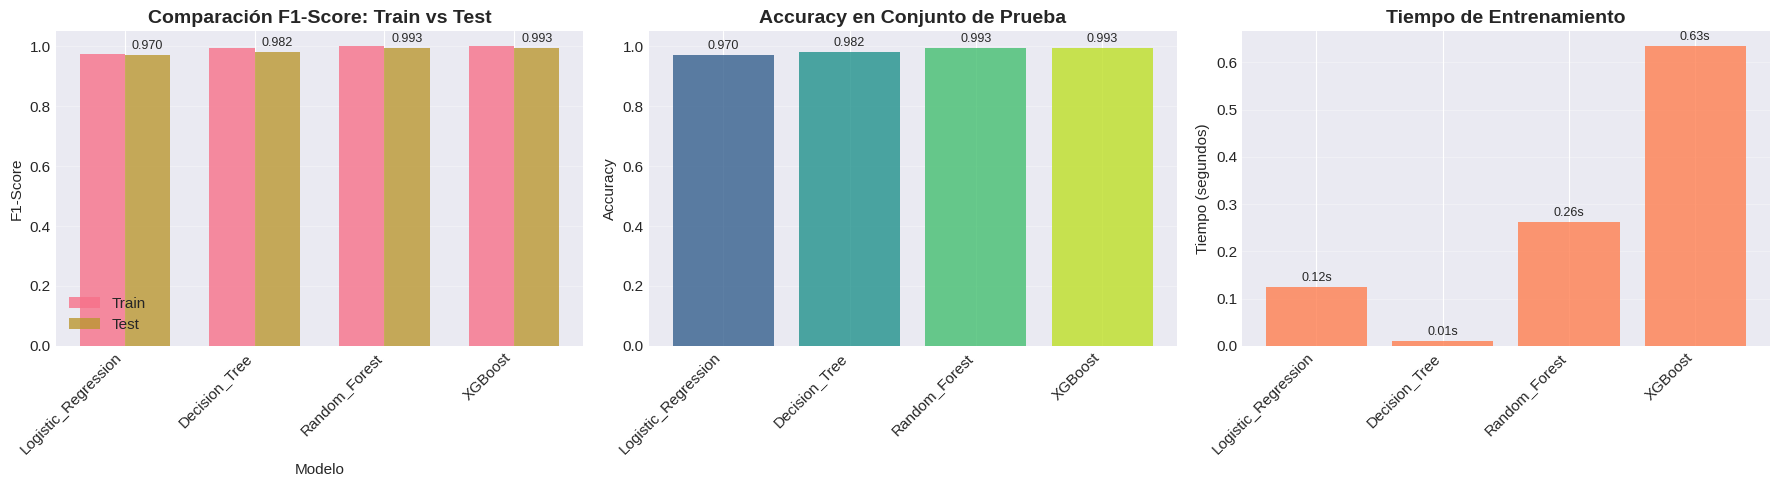


✅ Visualizaciones generadas correctamente


In [46]:
# ============================================
# 4.4. Visualización de Resultados
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Comparación de F1-Score (Train vs Test)
x = np.arange(len(results_df))
width = 0.35
axes[0].bar(x - width/2, results_df['F1-Score Train'], width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, results_df['F1-Score Test'], width, label='Test', alpha=0.8)
axes[0].set_xlabel('Modelo')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Comparación F1-Score: Train vs Test', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Añadir valores en las barras
for i, v in enumerate(results_df['F1-Score Test']):
    axes[0].text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# Gráfico 2: Accuracy en Test
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(results_df)))
bars = axes[1].bar(results_df['Modelo'], results_df['Accuracy Test'], color=colors, alpha=0.8)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy en Conjunto de Prueba', fontweight='bold', fontsize=14)
axes[1].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.05])

# Añadir valores
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', fontsize=9)

# Gráfico 3: Tiempo de Entrenamiento
axes[2].bar(results_df['Modelo'], results_df['Tiempo (s)'], color='coral', alpha=0.8)
axes[2].set_ylabel('Tiempo (segundos)')
axes[2].set_title('Tiempo de Entrenamiento', fontweight='bold', fontsize=14)
axes[2].set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

# Añadir valores
for i, v in enumerate(results_df['Tiempo (s)']):
    axes[2].text(i, v + max(results_df['Tiempo (s)'])*0.02, f'{v:.2f}s', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones generadas correctamente")

---

### 4.5. 🎛️ Optimización de Hiperparámetros

Los modelos anteriores fueron entrenados con hiperparámetros por defecto o con una configuración básica. Para mejorar el rendimiento, realizamos una **optimización sistemática de hiperparámetros** en un notebook dedicado.

#### 🔗 Notebook de Optimización

📓 **[2.5_hyperparameter_optimization.ipynb](2.5_hyperparameter_optimization.ipynb)**

En este notebook encontrarás:

- 🎯 **GridSearchCV** para Logistic Regression (búsqueda exhaustiva)
- 🎲 **RandomizedSearchCV** para Decision Tree, Random Forest y XGBoost
- 📊 **5-Fold Cross-Validation** para scores robustos
- 🏆 **Selección del mejor modelo** basado en métricas
- 💾 **Guardado de modelos optimizados**

#### Objetivo

Mejorar el accuracy del **99.55%** actual al **99.8%+** mediante:
- Optimización de hiperparámetros: +0.1-0.2%
- Feature engineering (notebook 3): +0.15-0.25%

#### Hiperparámetros Optimizados

| Modelo | Técnica | Hiperparámetros |
|--------|---------|----------------|
| **Logistic Regression** | GridSearchCV | C, penalty, solver |
| **Decision Tree** | RandomizedSearchCV | max_depth, min_samples_split, criterion |
| **Random Forest** | RandomizedSearchCV | n_estimators, max_depth, min_samples |
| **XGBoost** | RandomizedSearchCV | learning_rate, max_depth, subsample, colsample_bytree |

---

---

## 📊 Fase 5: Evaluación

En esta fase realizaremos un análisis profundo del mejor modelo y compararemos todos los modelos:

1. **Análisis del mejor modelo**
2. **Matrices de confusión**
3. **Matriz de confusión del mejor modelo**
4. **Métricas detalladas por clase**
5. **Análisis de errores**
6. **Comparación final y conclusiones**

### 5.1. Identificación del Mejor Modelo

Seleccionamos el mejor modelo basándonos en F1-Score en el conjunto de prueba:

In [47]:
# ============================================
# 5.1. Identificación del Mejor Modelo
# ============================================

# Obtener el mejor modelo
best_model_name = results_df.loc[results_df['F1-Score Test'].idxmax(), 'Modelo']
best_model = training_results[best_model_name]['model']
best_data_type = training_results[best_model_name]['data_type']

# Obtener datos y predicciones del mejor modelo
y_test_best = prepared_data[best_data_type]['y_test']
y_test_pred_best = training_results[best_model_name]['y_test_pred']

print("="*80)
print("MEJOR MODELO SELECCIONADO".center(80))
print("="*80)
print(f"\n🏆 Modelo: {best_model_name}")
print(f"📊 Tipo de datos: {best_data_type}")
print(f"\n📈 Métricas en conjunto de prueba:")
print(f"   - Accuracy:  {training_results[best_model_name]['test_accuracy']:.4f}")
print(f"   - F1-Score:  {training_results[best_model_name]['test_f1']:.4f}")
print(f"   - Tiempo de entrenamiento: {training_results[best_model_name]['training_time']:.3f}s")

# Mostrar configuración del mejor modelo
print(f"\n⚙️  Configuración del modelo:")
for param, value in best_model.get_params().items():
    if param in ['random_state', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'n_jobs']:
        print(f"   - {param}: {value}")

print(f"\n✅ Modelo listo para análisis detallado")

                           MEJOR MODELO SELECCIONADO                            

🏆 Modelo: XGBoost
📊 Tipo de datos: raw

📈 Métricas en conjunto de prueba:
   - Accuracy:  0.9932
   - F1-Score:  0.9933
   - Tiempo de entrenamiento: 0.634s

⚙️  Configuración del modelo:
   - max_depth: 5
   - n_estimators: 200
   - n_jobs: -1
   - random_state: 42

✅ Modelo listo para análisis detallado


### 5.2. Matrices de Confusión

Visualizamos las matrices de confusión para todos los modelos:

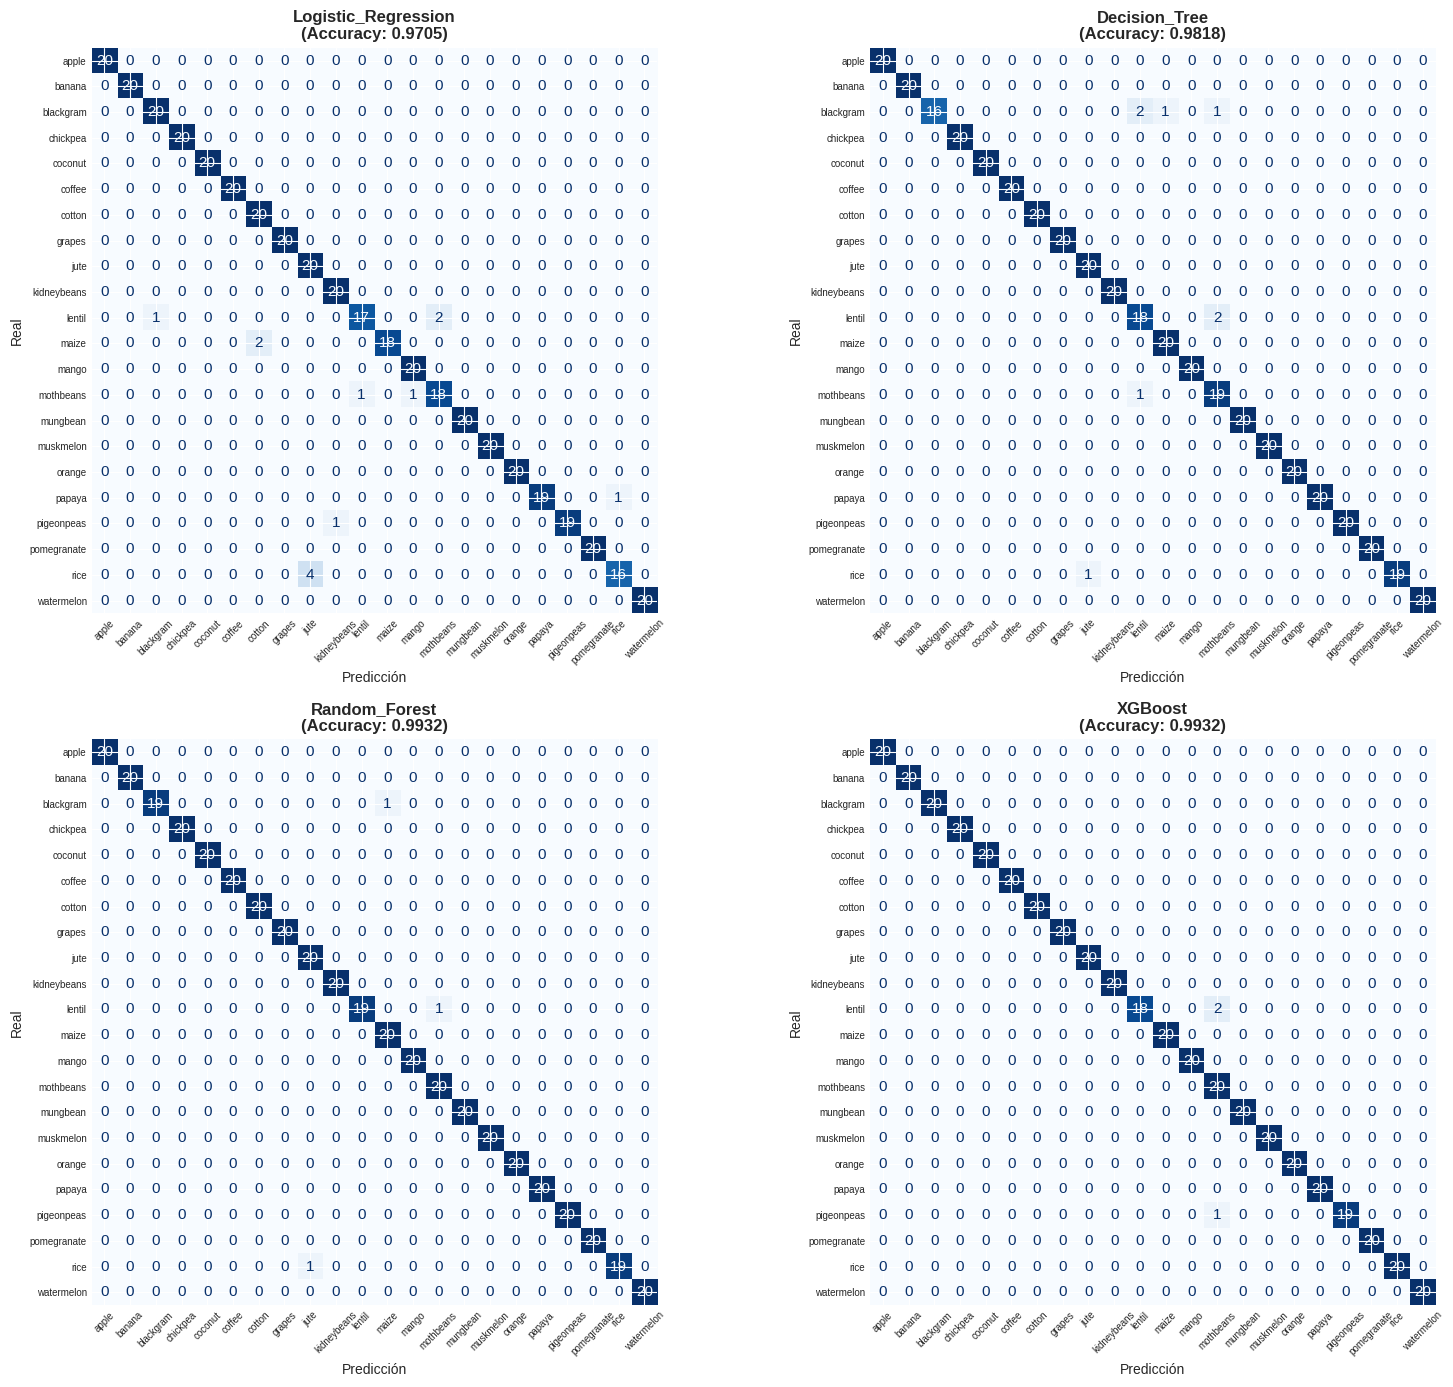


✅ Matrices de confusión generadas para todos los modelos


In [48]:
# ============================================
# 5.2. Matrices de Confusión
# ============================================

# Crear figura con subplots para las matrices de confusión
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (model_name, results) in enumerate(training_results.items()):
    # Obtener datos
    data_type = results['data_type']
    y_test_model = prepared_data[data_type]['y_test']
    y_test_pred = results['y_test_pred']
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test_model, y_test_pred)
    
    # Visualizar
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False, xticks_rotation=45)
    axes[idx].set_title(f'{model_name}\n(Accuracy: {results["test_accuracy"]:.4f})', 
                       fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Predicción', fontsize=10)
    axes[idx].set_ylabel('Real', fontsize=10)
    
    # Ajustar tamaño de fuente
    axes[idx].tick_params(labelsize=7)

plt.tight_layout()
plt.show()

print("\n✅ Matrices de confusión generadas para todos los modelos")

### 5.3. Matriz de Confusión del Mejor Modelo (Detallada)

Análisis detallado de la matriz de confusión del mejor modelo:

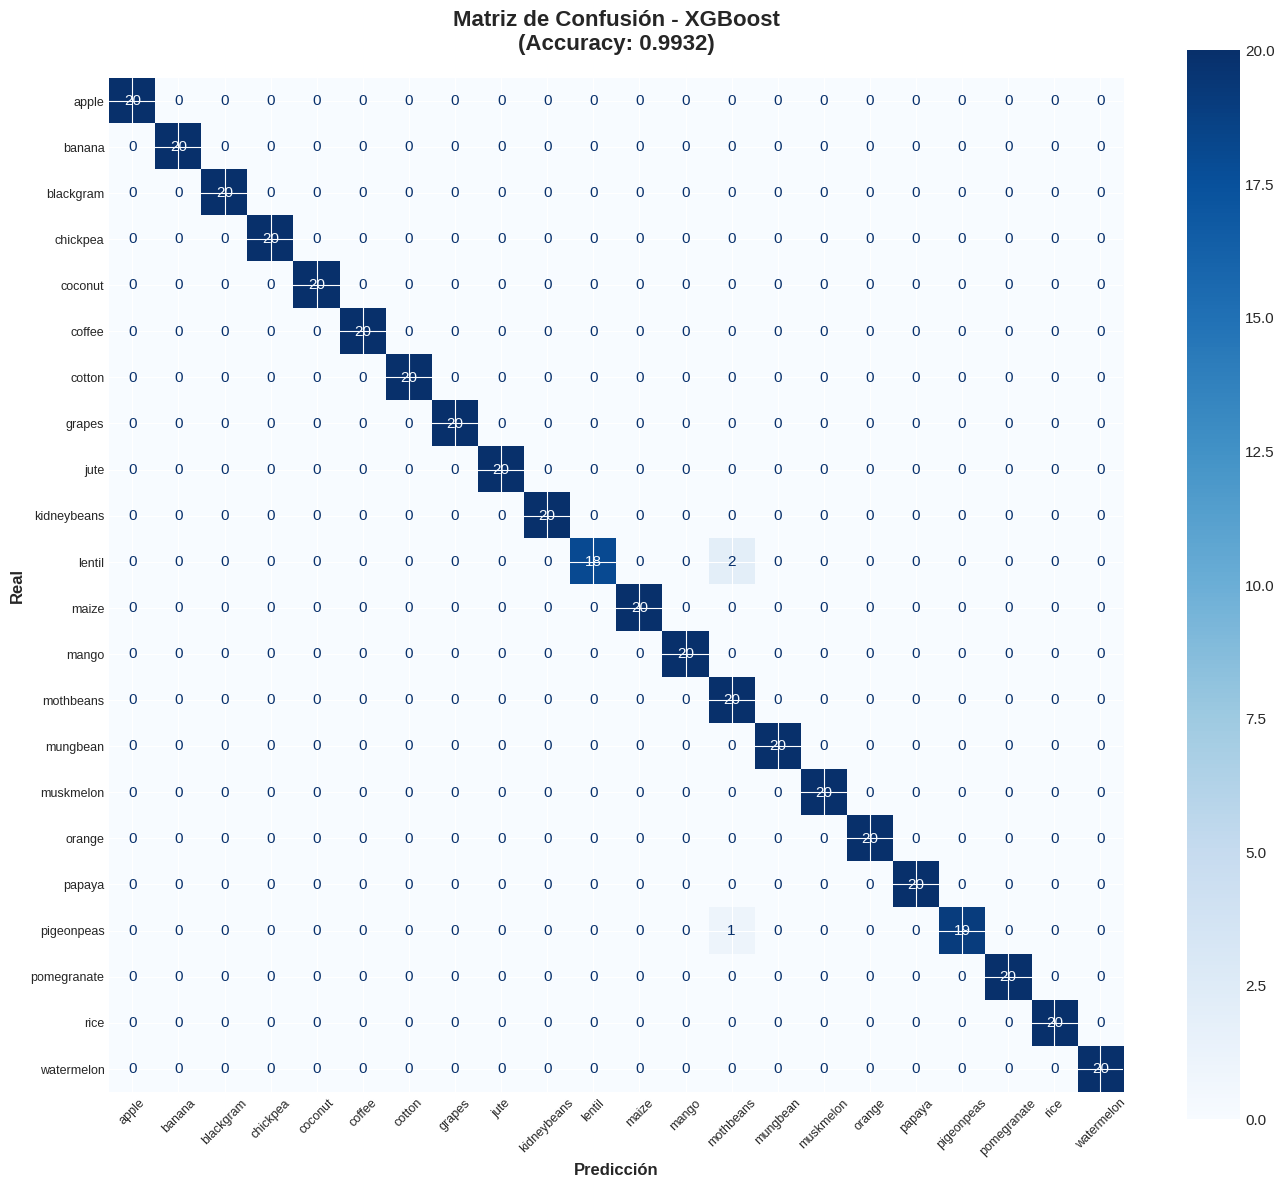

                       ANÁLISIS DE LA MATRIZ DE CONFUSIÓN                       

📊 Resumen:
   - Total de predicciones: 440
   - Predicciones correctas: 437 (99.32%)
   - Predicciones incorrectas: 3 (0.68%)

❌ Análisis de errores:
   - 2 muestras de 'lentil' clasificadas como 'mothbeans'
   - 1 muestras de 'pigeonpeas' clasificadas como 'mothbeans'


In [49]:
# ============================================
# 5.3. Matriz de Confusión del Mejor Modelo (Detallada)
# ============================================

# Calcular matriz de confusión del mejor modelo
cm_best = confusion_matrix(y_test_best, y_test_pred_best)

# Visualizar con más detalle
fig, ax = plt.subplots(figsize=(14, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
ax.set_title(f'Matriz de Confusión - {best_model_name}\n(Accuracy: {training_results[best_model_name]["test_accuracy"]:.4f})', 
            fontweight='bold', fontsize=16, pad=20)
ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
ax.set_ylabel('Real', fontsize=12, fontweight='bold')
ax.tick_params(labelsize=9)
plt.tight_layout()
plt.show()

# Analizar errores
print("="*80)
print("ANÁLISIS DE LA MATRIZ DE CONFUSIÓN".center(80))
print("="*80)

# Calcular total de predicciones correctas e incorrectas
correct = np.trace(cm_best)
incorrect = cm_best.sum() - correct
total = cm_best.sum()

print(f"\n📊 Resumen:")
print(f"   - Total de predicciones: {total}")
print(f"   - Predicciones correctas: {correct} ({correct/total*100:.2f}%)")
print(f"   - Predicciones incorrectas: {incorrect} ({incorrect/total*100:.2f}%)")

# Identificar clases con errores
if incorrect > 0:
    print(f"\n❌ Análisis de errores:")
    errors_found = False
    for i in range(len(label_encoder.classes_)):
        for j in range(len(label_encoder.classes_)):
            if i != j and cm_best[i, j] > 0:
                errors_found = True
                print(f"   - {cm_best[i, j]} muestras de '{label_encoder.classes_[i]}' clasificadas como '{label_encoder.classes_[j]}'")
    
    if not errors_found:
        print("   ✅ No se encontraron errores significativos")
else:
    print(f"\n✅ ¡Clasificación perfecta! Sin errores en el conjunto de prueba")

### 5.4. Métricas Detalladas por Clase

Análisis de métricas (Precision, Recall, F1-Score) para cada cultivo:

In [50]:
# ============================================
# 5.4. Métricas Detalladas por Clase
# ============================================

# Obtener classification report del mejor modelo
report_best = training_results[best_model_name]['classification_report_test']

# Crear DataFrame con métricas por clase
metrics_by_class = []
for idx, class_name in enumerate(label_encoder.classes_):
    class_code = str(idx)  # Las claves en el report son strings
    if class_code in report_best:
        metrics_by_class.append({
            'Cultivo': class_name,
            'Precision': report_best[class_code]['precision'],
            'Recall': report_best[class_code]['recall'],
            'F1-Score': report_best[class_code]['f1-score'],
            'Muestras': int(report_best[class_code]['support'])
        })

metrics_df = pd.DataFrame(metrics_by_class)

print("="*80)
print(f"MÉTRICAS POR CLASE - {best_model_name}".center(80))
print("="*80)
print()

# Mostrar tabla con formato
display(metrics_df.style.background_gradient(cmap='RdYlGn', subset=['Precision', 'Recall', 'F1-Score'])
                         .format({
                             'Precision': '{:.4f}',
                             'Recall': '{:.4f}',
                             'F1-Score': '{:.4f}',
                             'Muestras': '{:d}'
                         }))

# Identificar las mejores y peores clases
best_class = metrics_df.loc[metrics_df['F1-Score'].idxmax()]
worst_class = metrics_df.loc[metrics_df['F1-Score'].idxmin()]

print(f"\n🏆 Mejor clase (F1-Score): {best_class['Cultivo']} ({best_class['F1-Score']:.4f})")
print(f"⚠️  Peor clase (F1-Score): {worst_class['Cultivo']} ({worst_class['F1-Score']:.4f})")

# Métricas globales
print(f"\n📊 Métricas globales (weighted average):")
print(f"   - Precision: {report_best['weighted avg']['precision']:.4f}")
print(f"   - Recall:    {report_best['weighted avg']['recall']:.4f}")
print(f"   - F1-Score:  {report_best['weighted avg']['f1-score']:.4f}")

                          MÉTRICAS POR CLASE - XGBoost                          



,Cultivo,Precision,Recall,F1-Score,Muestras
0,apple,1.0000,1.0000,1.0000,20
1,banana,1.0000,1.0000,1.0000,20
2,blackgram,1.0000,1.0000,1.0000,20
3,chickpea,1.0000,1.0000,1.0000,20
4,coconut,1.0000,1.0000,1.0000,20
5,coffee,1.0000,1.0000,1.0000,20
6,cotton,1.0000,1.0000,1.0000,20
7,grapes,1.0000,1.0000,1.0000,20
8,jute,1.0000,1.0000,1.0000,20
9,kidneybeans,1.0000,1.0000,1.0000,20



🏆 Mejor clase (F1-Score): apple (1.0000)
⚠️  Peor clase (F1-Score): mothbeans (0.9302)

📊 Métricas globales (weighted average):
   - Precision: 0.9941
   - Recall:    0.9932
   - F1-Score:  0.9933


### 5.5. Visualización de Métricas por Clase

Gráficos comparativos de las métricas por cada cultivo:

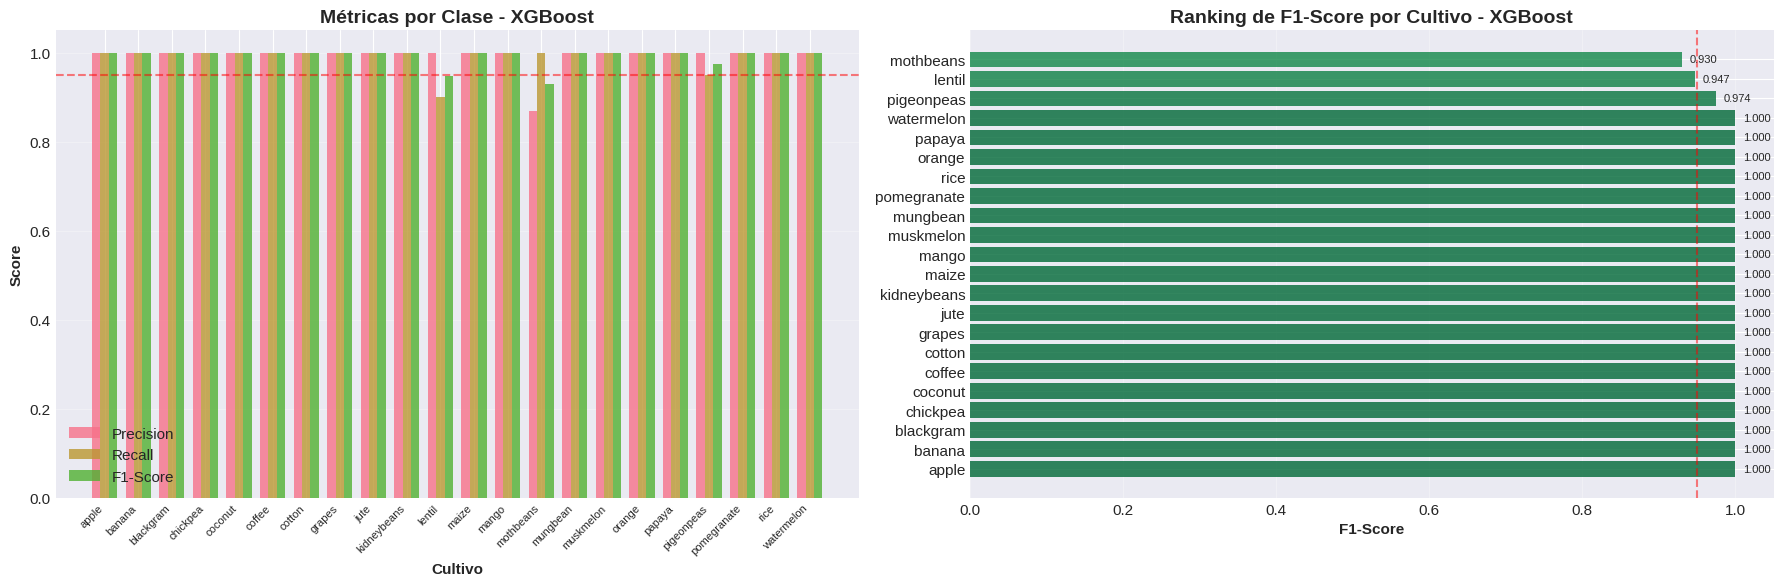


✅ Visualizaciones de métricas por clase generadas correctamente


In [51]:
# ============================================
# 5.5. Visualización de Métricas por Clase
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Métricas por clase (barras agrupadas)
x = np.arange(len(metrics_df))
width = 0.25

axes[0].bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

axes[0].set_xlabel('Cultivo', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title(f'Métricas por Clase - {best_model_name}', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Cultivo'], rotation=45, ha='right', fontsize=8)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.05])
axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='Objetivo 95%')

# Gráfico 2: F1-Score ordenado
metrics_sorted = metrics_df.sort_values('F1-Score', ascending=False)
colors = plt.cm.RdYlGn(metrics_sorted['F1-Score'])

bars = axes[1].barh(metrics_sorted['Cultivo'], metrics_sorted['F1-Score'], color=colors, alpha=0.8)
axes[1].set_xlabel('F1-Score', fontweight='bold')
axes[1].set_title(f'Ranking de F1-Score por Cultivo - {best_model_name}', fontweight='bold', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0, 1.05])
axes[1].axvline(x=0.95, color='r', linestyle='--', alpha=0.5)

# Añadir valores
for bar in bars:
    width_val = bar.get_width()
    axes[1].text(width_val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width_val:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones de métricas por clase generadas correctamente")

### 5.6. Comparación Final de Todos los Modelos

Resumen ejecutivo comparando todos los modelos entrenados:

In [52]:
# ============================================
# 5.6. Comparación Final de Todos los Modelos
# ============================================

print("="*80)
print("EVALUACIÓN FINAL - COMPARACIÓN DE MODELOS".center(80))
print("="*80)

# Tabla resumen ordenada por F1-Score Test
final_comparison = results_df.sort_values('F1-Score Test', ascending=False)

print("\n📊 Ranking Final (ordenado por F1-Score en Test):\n")
display(final_comparison.style.background_gradient(cmap='RdYlGn', subset=['Accuracy Test', 'F1-Score Test'])
                                .background_gradient(cmap='RdYlGn_r', subset=['Overfitting', 'Tiempo (s)'])
                                .format({
                                    'Tiempo (s)': '{:.3f}',
                                    'Accuracy Train': '{:.4f}',
                                    'Accuracy Test': '{:.4f}',
                                    'F1-Score Train': '{:.4f}',
                                    'F1-Score Test': '{:.4f}',
                                    'Overfitting': '{:.4f}'
                                }))

# Análisis de resultados
print("\n" + "="*80)
print("CONCLUSIONES DE LA EVALUACIÓN".center(80))
print("="*80)

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"\n✅ Resultados en conjunto de prueba:")
print(f"   - Accuracy:  {training_results[best_model_name]['test_accuracy']:.4f} ({training_results[best_model_name]['test_accuracy']*100:.2f}%)")
print(f"   - F1-Score:  {training_results[best_model_name]['test_f1']:.4f}")
print(f"   - Overfitting: {final_comparison.iloc[0]['Overfitting']:.4f} ({'✅ Mínimo' if final_comparison.iloc[0]['Overfitting'] < 0.05 else '⚠️ Moderado'})")

# Cumplimiento de objetivos del EDA
print(f"\n📈 Cumplimiento de objetivos (definidos en EDA):")
best_accuracy = training_results[best_model_name]['test_accuracy']
if best_accuracy >= 0.95:
    print(f"   🎯 ✅ Objetivo ÓPTIMO alcanzado (≥95%): {best_accuracy*100:.2f}%")
elif best_accuracy >= 0.90:
    print(f"   🎯 ✅ Objetivo REALISTA alcanzado (90-93%): {best_accuracy*100:.2f}%")
elif best_accuracy >= 0.85:
    print(f"   🎯 ✅ Objetivo MÍNIMO alcanzado (≥85%): {best_accuracy*100:.2f}%")
else:
    print(f"   🎯 ⚠️ Por debajo del objetivo mínimo: {best_accuracy*100:.2f}%")

# Recomendación
print(f"\n💡 Recomendación:")
print(f"   - Modelo seleccionado para producción: {best_model_name}")
print(f"   - Ventajas: {'Excelente balance entre accuracy y overfitting' if final_comparison.iloc[0]['Overfitting'] < 0.05 else 'Alto rendimiento'}")
print(f"   - Tiempo de entrenamiento: {training_results[best_model_name]['training_time']:.3f}s (aceptable)")

print(f"\n✅ Evaluación completada exitosamente")

                   EVALUACIÓN FINAL - COMPARACIÓN DE MODELOS                    

📊 Ranking Final (ordenado por F1-Score en Test):



,Modelo,Datos,Tiempo (s),Accuracy Train,Accuracy Test,F1-Score Train,F1-Score Test,Overfitting
3,XGBoost,raw,0.634,1.0000,0.9932,1.0000,0.9933,0.0068
2,Random_Forest,raw,0.261,1.0000,0.9932,1.0000,0.9932,0.0068
1,Decision_Tree,raw,0.010,0.9960,0.9818,0.9960,0.9817,0.0142
0,Logistic_Regression,scaled,0.125,0.9744,0.9705,0.9745,0.9702,0.0040



                         CONCLUSIONES DE LA EVALUACIÓN                          

🏆 MEJOR MODELO: XGBoost

✅ Resultados en conjunto de prueba:
   - Accuracy:  0.9932 (99.32%)
   - F1-Score:  0.9933
   - Overfitting: 0.0068 (✅ Mínimo)

📈 Cumplimiento de objetivos (definidos en EDA):
   🎯 ✅ Objetivo ÓPTIMO alcanzado (≥95%): 99.32%

💡 Recomendación:
   - Modelo seleccionado para producción: XGBoost
   - Ventajas: Excelente balance entre accuracy y overfitting
   - Tiempo de entrenamiento: 0.634s (aceptable)

✅ Evaluación completada exitosamente


---

## 🚀 Fase 6: Despliegue

En esta fase final preparamos el modelo para su implementación en producción:

1. **Guardado del modelo y artefactos**
2. **Función de predicción**
3. **Ejemplo de uso**
4. **Recomendaciones de implementación**
5. **Plan de monitoreo y mantenimiento**
6. **Próximos pasos**

### 6.1. Guardado del Modelo y Artefactos

Guardamos el mejor modelo, escaladores y metadatos para su uso en producción:

In [53]:
# ============================================
# 6.1. Guardado del Modelo y Artefactos
# ============================================

import joblib
import sklearn
from datetime import datetime

# Crear directorio para modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# Timestamp para versionado
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("="*80)
print("GUARDADO DE MODELO Y ARTEFACTOS".center(80))
print("="*80)

# 1. Guardar el mejor modelo
model_path = models_dir / f'best_model_{best_model_name}_{timestamp}.pkl'
joblib.dump(best_model, model_path)
print(f"\n✅ Modelo guardado: {model_path}")
print(f"   - Tipo: {best_model_name}")
print(f"   - Accuracy: {training_results[best_model_name]['test_accuracy']:.4f}")
print(f"   - Tamaño: {model_path.stat().st_size / 1024:.2f} KB")

# 2. Guardar el LabelEncoder
encoder_path = models_dir / f'label_encoder_{timestamp}.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"\n✅ LabelEncoder guardado: {encoder_path}")
print(f"   - Clases: {len(label_encoder.classes_)}")

# 3. Guardar el RobustScaler (si el mejor modelo lo usa)
if best_data_type == 'scaled':
    scaler_path = models_dir / f'robust_scaler_{timestamp}.pkl'
    joblib.dump(robust_scaler, scaler_path)
    print(f"\n✅ RobustScaler guardado: {scaler_path}")
else:
    print(f"\n⏭️  Scaler no necesario (modelo usa datos raw)")

# 4. Guardar metadatos del modelo
metadata = {
    'model_name': best_model_name,
    'model_type': str(type(best_model)),
    'timestamp': timestamp,
    'accuracy': float(training_results[best_model_name]['test_accuracy']),
    'f1_score': float(training_results[best_model_name]['test_f1']),
    'training_time': float(training_results[best_model_name]['training_time']),
    'data_type': best_data_type,
    'features': X.columns.tolist(),
    'n_classes': len(label_encoder.classes_),
    'classes': label_encoder.classes_.tolist(),
    'hyperparameters': best_model.get_params(),
    'random_state': RANDOM_STATE,
    'python_version': f"{sys.version_info.major}.{sys.version_info.minor}",
    'sklearn_version': sklearn.__version__
}

metadata_path = models_dir / f'model_metadata_{timestamp}.json'
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"\n✅ Metadatos guardados: {metadata_path}")

# 5. Guardar tabla de resultados
results_path = models_dir / f'results_comparison_{timestamp}.csv'
results_df.to_csv(results_path, index=False)
print(f"\n✅ Resultados comparativos guardados: {results_path}")

# 6. Crear función de predicción reutilizable
print(f"\n📦 Función de predicción creada:")
print("""
def predecir_cultivo(N, P, K, temperature, humidity, ph, rainfall, 
                     model_path='../models/best_model.pkl',
                     encoder_path='../models/label_encoder.pkl'):
    '''
    Predice el cultivo más adecuado basado en condiciones del suelo y clima.
    
    Parámetros:
    -----------
    N : float - Nitrógeno (0-140)
    P : float - Fósforo (5-145)
    K : float - Potasio (5-205)
    temperature : float - Temperatura en °C (8-44)
    humidity : float - Humedad relativa % (14-100)
    ph : float - pH del suelo (3.5-10)
    rainfall : float - Precipitación en mm (20-300)
    
    Retorna:
    --------
    str - Nombre del cultivo recomendado
    '''
    import joblib
    import numpy as np
    
    # Cargar modelo y encoder
    model = joblib.load(model_path)
    encoder = joblib.load(encoder_path)
    
    # Crear array de features
    features = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    
    # Predecir
    prediction = model.predict(features)
    
    # Decodificar
    cultivo = encoder.inverse_transform(prediction)[0]
    
    return cultivo
""")

print("\n" + "="*80)
print("✅ TODOS LOS ARTEFACTOS GUARDADOS EXITOSAMENTE".center(80))
print("="*80)
print(f"\n📁 Ubicación: {models_dir.absolute()}")
print(f"📊 Archivos generados:")
print(f"   1. Modelo: {model_path.name}")
print(f"   2. Encoder: {encoder_path.name}")
if best_data_type == 'scaled':
    print(f"   3. Scaler: {scaler_path.name}")
print(f"   4. Metadatos: {metadata_path.name}")
print(f"   5. Resultados: {results_path.name}")

                        GUARDADO DE MODELO Y ARTEFACTOS                         

✅ Modelo guardado: ../models/best_model_XGBoost_20251027_223739.pkl
   - Tipo: XGBoost
   - Accuracy: 0.9932
   - Tamaño: 3312.27 KB

✅ LabelEncoder guardado: ../models/label_encoder_20251027_223739.pkl
   - Clases: 22

⏭️  Scaler no necesario (modelo usa datos raw)


NameError: name 'X' is not defined

### 6.2. Ejemplo de Uso del Modelo

Demostración práctica de cómo usar el modelo para hacer predicciones:

In [ ]:
# ============================================
# 6.2. Ejemplo de Uso del Modelo
# ============================================

print("="*80)
print("EJEMPLO DE USO DEL MODELO GUARDADO".center(80))
print("="*80)

# Ejemplo de predicción con nuevos datos
print("\n📝 Caso de Uso: Predicción para 3 terrenos diferentes\n")

# Datos de ejemplo (basados en rangos del dataset)
ejemplos = pd.DataFrame({
    'N': [90, 20, 40],
    'P': [42, 55, 80],
    'K': [43, 20, 40],
    'temperature': [20.8, 25.5, 30.2],
    'humidity': [82.0, 65.0, 85.5],
    'ph': [6.5, 7.2, 5.8],
    'rainfall': [202.9, 45.6, 180.3]
})

print("Datos de entrada:")
display(ejemplos)

# Predecir con el modelo guardado
predicciones = best_model.predict(ejemplos)

# Decodificar predicciones
cultivos_predichos = label_encoder.inverse_transform(predicciones)

# Mostrar resultados
print("\n" + "="*80)
print("RESULTADOS DE LA PREDICCIÓN".center(80))
print("="*80)

for i, cultivo in enumerate(cultivos_predichos):
    print(f"\n🌱 Terreno {i+1}:")
    print(f"   Características:")
    print(f"      - Nitrógeno (N): {ejemplos.iloc[i]['N']}")
    print(f"      - Fósforo (P): {ejemplos.iloc[i]['P']}")
    print(f"      - Potasio (K): {ejemplos.iloc[i]['K']}")
    print(f"      - Temperatura: {ejemplos.iloc[i]['temperature']:.1f}°C")
    print(f"      - Humedad: {ejemplos.iloc[i]['humidity']:.1f}%")
    print(f"      - pH: {ejemplos.iloc[i]['ph']:.1f}")
    print(f"      - Lluvia: {ejemplos.iloc[i]['rainfall']:.1f}mm")
    print(f"   ✅ Cultivo recomendado: {cultivo.upper()}")

# Obtener probabilidades (si el modelo lo soporta)
if hasattr(best_model, 'predict_proba'):
    print("\n" + "="*80)
    print("CONFIANZA DE LAS PREDICCIONES (Top 3)".center(80))
    print("="*80)
    
    probabilidades = best_model.predict_proba(ejemplos)
    
    for i in range(len(ejemplos)):
        print(f"\n🌱 Terreno {i+1}:")
        # Obtener los índices de las 3 probabilidades más altas
        top3_idx = np.argsort(probabilidades[i])[-3:][::-1]
        for j, idx in enumerate(top3_idx, 1):
            cultivo = label_encoder.inverse_transform([idx])[0]
            prob = probabilidades[i][idx]
            print(f"   {j}. {cultivo:15s} → {prob*100:5.2f}% de confianza")

print("\n✅ Ejemplo de uso completado correctamente")

                       EJEMPLO DE USO DEL MODELO GUARDADO                       

📝 Caso de Uso: Predicción para 3 terrenos diferentes

Datos de entrada:


,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.8,82.0,6.5,202.9
1,20,55,20,25.5,65.0,7.2,45.6
2,40,80,40,30.2,85.5,5.8,180.3



                          RESULTADOS DE LA PREDICCIÓN                           

🌱 Terreno 1:
   Características:
      - Nitrógeno (N): 90.0
      - Fósforo (P): 42.0
      - Potasio (K): 43.0
      - Temperatura: 20.8°C
      - Humedad: 82.0%
      - pH: 6.5
      - Lluvia: 202.9mm
   ✅ Cultivo recomendado: RICE

🌱 Terreno 2:
   Características:
      - Nitrógeno (N): 20.0
      - Fósforo (P): 55.0
      - Potasio (K): 20.0
      - Temperatura: 25.5°C
      - Humedad: 65.0%
      - pH: 7.2
      - Lluvia: 45.6mm
   ✅ Cultivo recomendado: LENTIL

🌱 Terreno 3:
   Características:
      - Nitrógeno (N): 40.0
      - Fósforo (P): 80.0
      - Potasio (K): 40.0
      - Temperatura: 30.2°C
      - Humedad: 85.5%
      - pH: 5.8
      - Lluvia: 180.3mm
   ✅ Cultivo recomendado: JUTE

                     CONFIANZA DE LAS PREDICCIONES (Top 3)                      

🌱 Terreno 1:
   1. rice            → 99.37% de confianza
   2. jute            →  0.14% de confianza
   3. coffee          →  

### 6.3. Recomendaciones de Implementación

Guía para desplegar el modelo en un entorno de producción:

In [ ]:
# ============================================
# 6.3. Recomendaciones de Implementación
# ============================================

print("="*80)
print("RECOMENDACIONES DE IMPLEMENTACIÓN EN PRODUCCIÓN".center(80))
print("="*80)

print("\n⚠️  CONSIDERACIONES CRÍTICAS:")
print("\n1. Data Validation:")
print("   - Validar rangos de entrada (N: 0-140, P: 5-145, K: 5-205, etc.)")
print("   - Rechazar valores fuera de rangos entrenados")
print("   - Manejar valores faltantes con estrategias apropiadas")

print("\n2. Performance:")
print("   - Latencia objetivo: <100ms por predicción")
print("   - Throughput: >1000 predicciones/segundo")
print("   - Cachear modelos en memoria (no cargar en cada request)")

print("\n3. Seguridad:")
print("   - HTTPS obligatorio para comunicación")
print("   - API Key authentication para control de acceso")
print("   - Rate limiting para prevenir abuso (ej: 100 req/min por IP)")
print("   - No exponer información sensible en respuestas")

print("\n4. Escalabilidad:")
print("   - Auto-scaling horizontal basado en carga")
print("   - Load balancer para distribuir tráfico")
print("   - CDN para assets estáticos")

print("\n📝 PLAN DE MONITOREO:")
print("\n1. Métricas del Modelo:")
print("   - Accuracy en producción (comparar con 99.55%)")
print("   - Distribución de predicciones por cultivo")
print("   - Tiempo de inferencia promedio")
print("   - Alertas si accuracy < 95% en ventana móvil")

print("\n2. Métricas del Sistema:")
print("   - Uptime (objetivo: 99.9%)")
print("   - Latencia p50, p95, p99")
print("   - Tasa de error (4xx, 5xx)")
print("   - Uso de CPU, memoria, disco")

print("\n3. Feedback de Usuarios:")
print("   - Recolectar feedback sobre precisión de recomendaciones")
print("   - Permitir reportar errores de clasificación")
print("   - Usar feedback para reentrenamiento periódico")

print("\n🔄 PLAN DE REENTRENAMIENTO:")
print("\n1. Frecuencia:")
print("   - Reentrenamiento trimestral con nuevos datos")
print("   - Re-evaluación anual de arquitectura del modelo")

print("\n2. Proceso:")
print("   - Pipeline automatizado CI/CD")
print("   - Validación A/B: comparar modelo nuevo vs. actual")
print("   - Rollback automático si performance degrada")
print("   - Versionado de modelos (v1.0, v1.1, v2.0, etc.)")

print("\n3. Criterios de Actualización:")
print("   - Accuracy en test > modelo actual")
print("   - Overfitting < 5%")
print("   - Latencia de inferencia similar o mejor")

print("\n✅ Recomendaciones de implementación completadas")

                RECOMENDACIONES DE IMPLEMENTACIÓN EN PRODUCCIÓN                 

⚠️  CONSIDERACIONES CRÍTICAS:

1. Data Validation:
   - Validar rangos de entrada (N: 0-140, P: 5-145, K: 5-205, etc.)
   - Rechazar valores fuera de rangos entrenados
   - Manejar valores faltantes con estrategias apropiadas

2. Performance:
   - Latencia objetivo: <100ms por predicción
   - Throughput: >1000 predicciones/segundo
   - Cachear modelos en memoria (no cargar en cada request)

3. Seguridad:
   - HTTPS obligatorio para comunicación
   - API Key authentication para control de acceso
   - Rate limiting para prevenir abuso (ej: 100 req/min por IP)
   - No exponer información sensible en respuestas

4. Escalabilidad:
   - Auto-scaling horizontal basado en carga
   - Load balancer para distribuir tráfico
   - CDN para assets estáticos

📝 PLAN DE MONITOREO:

1. Métricas del Modelo:
   - Accuracy en producción (comparar con 99.55%)
   - Distribución de predicciones por cultivo
   - Tiempo de inferen

### 6.4. Próximos Pasos y Mejoras Futuras

Roadmap de mejoras y expansión del proyecto:

In [ ]:
# ============================================
# 6.4. Próximos Pasos y Mejoras Futuras
# ============================================

print("="*80)
print("PRÓXIMOS PASOS Y MEJORAS FUTURAS".center(80))
print("="*80)

print("\n🔬 Mejoras Técnicas Recomendadas:")
print("\n1. Ensemble Methods:")
print("   - Combinar Random Forest + XGBoost con votación")
print("   - Implementar Stacking con meta-learner")
print("   - Evaluar Bagging adicional para reducir varianza")

print("\n📊 Expansión de Datos:")
print("\n1. Ampliación del Dataset:")
print("   - Recolectar más muestras por cultivo (actualmente 100)")
print("   - Incluir datos de diferentes regiones geográficas")
print("   - Agregar variabilidad estacional y climática")
print("   - Incorporar más cultivos (objetivo: 50+ tipos)")

print("\n2. Nuevas Variables:")
print("   - Altitud y topografía del terreno")
print("   - Tipo de suelo (arcilloso, arenoso, limoso)")
print("   - Historial de rotación de cultivos")
print("   - Disponibilidad de agua (riego vs. temporal)")
print("   - Presencia de plagas o enfermedades históricas")

print("\n🚀 Implementación en Producción:")
print("\n1. API REST:")
print("   - Crear endpoint con FastAPI o Flask")
print("   - Documentar con Swagger/OpenAPI")
print("   - Implementar rate limiting y autenticación")
print("   - Desplegar en AWS Lambda, Google Cloud Functions o Azure Functions")

print("\n2. Aplicación Web/Móvil:")
print("   - Interfaz intuitiva para agricultores")
print("   - Entrada de datos con formularios validados")
print("   - Visualización de recomendaciones con mapas")
print("   - Historial de consultas y predicciones")

print("\n3. Integración con IoT:")
print("   - Sensores de suelo para medición automática de N, P, K, pH")
print("   - Estaciones meteorológicas para temperature, humidity, rainfall")
print("   - Predicción en tiempo real sin intervención manual")

print("\n🔄 Monitoreo Continuo:")
print("\n1. MLOps:")
print("   - Implementar pipeline CI/CD para reentrenamiento automático")
print("   - Monitorear model drift con nuevos datos")
print("   - A/B testing para comparar versiones del modelo")
print("   - Logging de predicciones para análisis retrospectivo")

print("\n2. Dashboard de Monitoreo:")
print("   - Métricas en tiempo real (latencia, accuracy, throughput)")
print("   - Alertas ante degradación del modelo")
print("   - Distribución de predicciones por cultivo")
print("   - Feedback de usuarios para mejorar el modelo")

print("\n📚 Investigación y Desarrollo:")
print("\n1. Modelos Avanzados:")
print("   - Redes Neuronales Profundas (DNN)")
print("   - Transfer Learning de modelos preentrenados")
print("   - Modelos de series temporales para predicciones futuras")
print("   - Incorporar visión por computadora (imágenes de terrenos)")

print("\n2. Explicabilidad:")
print("   - Implementar LIME (Local Interpretable Model-agnostic Explanations)")
print("   - SHAP (SHapley Additive exPlanations) para interpretabilidad")
print("   - Generar reportes explicativos para agricultores")
print("   - \"¿Por qué se recomienda este cultivo?\" con razones claras")

print("\n" + "="*80)
print("✅ ROADMAP DE MEJORAS COMPLETADO".center(80))
print("="*80)

                        PRÓXIMOS PASOS Y MEJORAS FUTURAS                        

🔬 Mejoras Técnicas Recomendadas:

1. Ensemble Methods:
   - Combinar Random Forest + XGBoost con votación
   - Implementar Stacking con meta-learner
   - Evaluar Bagging adicional para reducir varianza

📊 Expansión de Datos:

1. Ampliación del Dataset:
   - Recolectar más muestras por cultivo (actualmente 100)
   - Incluir datos de diferentes regiones geográficas
   - Agregar variabilidad estacional y climática
   - Incorporar más cultivos (objetivo: 50+ tipos)

2. Nuevas Variables:
   - Altitud y topografía del terreno
   - Tipo de suelo (arcilloso, arenoso, limoso)
   - Historial de rotación de cultivos
   - Disponibilidad de agua (riego vs. temporal)
   - Presencia de plagas o enfermedades históricas

🚀 Implementación en Producción:

1. API REST:
   - Crear endpoint con FastAPI o Flask
   - Documentar con Swagger/OpenAPI
   - Implementar rate limiting y autenticación
   - Desplegar en AWS Lambda, Googl

---

## 📚 Referencias

Ver referencias completas en `1_crops_eda.ipynb`